In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dense
from keras.models import Sequential

In [2]:
IMAGE_SIZE =256
BATCH_SIZE= 16
CHANNELS= 3
EPOCHS=10

In [3]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "Main dataset-20230209T191052Z-001/",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3601 files belonging to 6 classes.


In [4]:
class_name =dataset.class_names
class_name

['Aphids',
 'Army worm',
 'Bacterial Blight',
 'Healthy',
 'Powdery Mildew',
 'Target spot']

In [5]:
len(dataset)

226

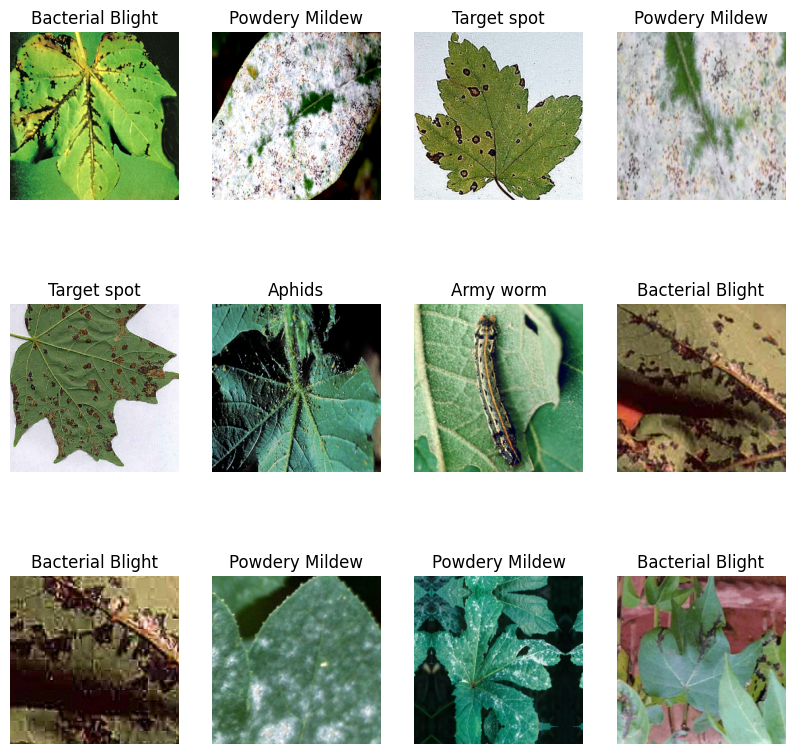

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [7]:
train_size = 0.8
len(dataset)*train_size

180.8

In [8]:
train_ds = dataset.take(181)
len(train_ds)


181

In [9]:
test_ds = dataset.skip(181)
len(test_ds)

45

In [10]:
val_size = 0.1
len(dataset)*val_size

22.6

In [11]:
val_ds = test_ds.take(23)
len(val_ds)

23

In [12]:
test_ds = test_ds.skip(23)
len(test_ds)

22

In [13]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size= tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
   layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [17]:
data_augmentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation= 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),
])

model.build(input_shape = input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define a callback to save the model weights
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint_{epoch:02d}.h5',  # Path to save the weights
                                      save_best_only=False,  #save all epoch
                                      save_weights_only=False,
                                      monitor='val_loss',   # Quantity to monitor (e.g., validation loss)
                                      mode='min',           # 'min' for loss, 'max' for accuracy, 'auto' for automatic
                                      verbose=1)            # Verbosity level

In [21]:
history =model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds,
    callbacks=[checkpoint_callback]
) 


Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 1.7716 - accuracy: 0.2293
Epoch 1: saving model to model_checkpoint_01.h5
180/180 [==============================] - 206s 1s/step - loss: 1.7716 - accuracy: 0.2293 - val_loss: 1.4896 - val_accuracy: 0.3636
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 1.4598 - accuracy: 0.4042
Epoch 2: saving model to model_checkpoint_02.h5
180/180 [==============================] - 177s 983ms/step - loss: 1.4598 - accuracy: 0.4042 - val_loss: 1.4589 - val_accuracy: 0.4545
Epoch 3/10
180/180 [==============================] - ETA: 0s - loss: 1.1968 - accuracy: 0.5382
Epoch 3: saving model to model_checkpoint_03.h5
180/180 [==============================] - 173s 960ms/step - loss: 1.1968 - accuracy: 0.5382 - val_loss: 1.1150 - val_accuracy: 0.5284
Epoch 4/10
180/180 [==============================] - ETA: 0s - loss: 1.0676 - accuracy: 0.5906
Epoch 4: saving model to model_checkpoint_04.h5
180/180 [=============

In [22]:
model.save('plant_disease_detection_model.h5')

In [23]:
checkpoint_path = './model_checkpoint_10.h5'
loaded_model = tf.keras.models.load_model(checkpoint_path)


In [24]:
history =model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds,
    callbacks=[checkpoint_callback]
) 


Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.7773
Epoch 1: saving model to model_checkpoint_01.h5
180/180 [==============================] - 177s 983ms/step - loss: 0.6265 - accuracy: 0.7773 - val_loss: 0.8031 - val_accuracy: 0.6818
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.8007
Epoch 2: saving model to model_checkpoint_02.h5
180/180 [==============================] - 178s 988ms/step - loss: 0.5667 - accuracy: 0.8007 - val_loss: 0.6430 - val_accuracy: 0.7415
Epoch 3/10
180/180 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.8356
Epoch 3: saving model to model_checkpoint_03.h5
180/180 [==============================] - 178s 992ms/step - loss: 0.4664 - accuracy: 0.8356 - val_loss: 0.5720 - val_accuracy: 0.7926
Epoch 4/10
180/180 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.8366
Epoch 4: saving model to model_checkpoint_04.h5
180/180 [==========

In [25]:
model.save('plant_disease_detection_model.h5')

In [26]:
history.history['accuracy']

[0.7773123979568481,
 0.8006981015205383,
 0.8356021046638489,
 0.8366492390632629,
 0.8432809710502625,
 0.860383927822113,
 0.8607329726219177,
 0.8806282877922058,
 0.8928446769714355,
 0.8802792429924011]

In [27]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss=history.history['val_loss']

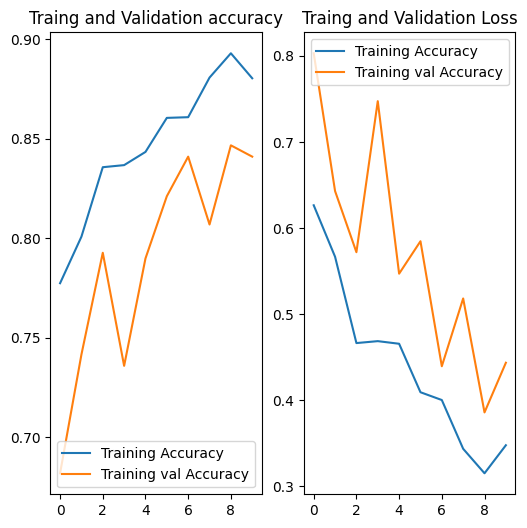

In [29]:
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Training val Accuracy")
plt.legend(loc="lower right")
plt.title("Traing and Validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Accuracy")
plt.plot(range(EPOCHS), val_loss, label="Training val Accuracy")
plt.legend(loc="upper right")
plt.title("Traing and Validation Loss")
plt.show()

predicted image is : 
actual label : Bacterial Blight
1/1 [==============================] - 1s 787ms/step
predicted label : Bacterial Blight


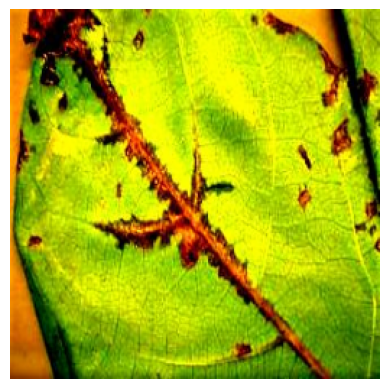

In [30]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("predicted image is : ")
    plt.imshow(first_image)
    print("actual label :",class_name[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label :",class_name[np.argmax(batch_prediction[0])])
    plt.axis("off")